# Write-up and code for Feb 13

## To Do
- ~~Implement Forward-View TD(Lambda) algorithm for Value Function Prediction~~
- ~~Implement Backward View TD(Lambda), i.e., Eligibility Traces algorithm for Value Function Prediction~~
- Implement these algorithms as offline or online algorithms (offline means updates happen only after a full simulation trace, online means updates happen at every time step)
- ~~Test these algorithms on some example MDPs, compare them versus DP Policy Evaluation, and plot their accuracy as a function of Lambda~~
- ~~Prove that Offline Forward-View TD(Lambda) and Offline Backward View TD(Lambda) are equivalent. We covered the proof of Lambda = 1 in class. Do the proof for arbitrary Lambda (similar telescoping argument as done in class) for the case where a state appears only once in an episode.~~

## Forward View TD($\lambda$) for Value Function Prediction

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from typing import List
from modules.MDP import MDP, Policy, V
from modules.state_action_vars import S, A
from modules.RL_prediction import generate_path, action_sampler
import numpy as np

def n_step_return(return_series: List[float], state_series: List[S], gamma: float, vf: V) -> np.ndarray:
    # returns all the n-step returns from 1 up to n
    n = len(return_series)
    g_n = np.zeros((n,1))
    
    for i in range(n-1):
        g_n[i:] += np.power(gamma, i) * return_series[i]
        g_n[i] += np.power(gamma, i+1) * vf[state_series[i]]
    g_n[-1] += np.power(gamma, n-1) * return_series[-1]
    return g_n


def sum_n_step_return(g_n: np.ndarray, lambd: float) -> float:
    # take in all the n-step returns and return the lambda summation form the slides
    g_lambda = 0
    for j, g in enumerate(g_n[:-1]):
        g_lambda += np.power(lambd, j) * g
        
    return (1.0-lambd)*g_lambda + np.power(lambd, g_n.shape[0]-1)*g_n[-1]


def lambda_returns(r_series: List[float], state_series: List[S], gamma: float, lambd: float, vf: V) -> float:
    # for computational efficiency, combine the calculation of n-step return and the lambda summation
    n = len(r_series)
    g_lambda = 0
    #g_n = np.zeros((n,1))
    #g_n = np.multiply(np.power(gamma, np.arange(n)), np.asarray(return_series))
    g_n = 0
    
    for j in range(n-1):
        g_n += np.power(gamma, j) * r_series[j]
        g_lambda += np.power(lambd, j) * (g_n + np.power(gamma, j+1) * vf[state_series[j]])
        
    g_n += np.power(gamma, n-1) * r_series[-1]

    return (1.0-lambd)*g_lambda + np.power(lambd, n-1)*g_n


def forward_view_TD_lambda(policy: Policy, mdp: MDP, lambd: float, num_epi: int, num_steps: int, alpha: float) -> V:
    # implementation of forward view TD(lambda) as it is outlined in the lecture slides
    v = {}
    gamma = mdp.gamma
    for s in mdp.States:
        v[s] = 0

    for i in range(num_epi):
        # generate an episode
        s_list, _, r_list = generate_path(policy, mdp, num_steps)

        for j in range(num_steps):
#             g_n = n_step_return(r_list[j:], s_list[j:], gamma, v)
#             g_lambd = sum_n_step_return(g_n, lambd)
            g_lambd = lambda_returns(r_list[j:], s_list[j:], gamma, lambd, v)
            v[s_list[j]] += float(alpha * (g_lambd - v[s_list[j]]))

    return v

## Backward View TD($\lambda$) for Value Function Prediction

In [3]:
from modules.RL_interface import RL_interface
import random

def backward_view_TD_lambda(policy: Policy, mdp: MDP, lambd: float, num_epi: int, num_steps: int, alpha: float) -> V:
    # implementation of backward view TD(lambda) as it is outlined in the lecture slides

    v = {}
    # keep a dictionary that maps states to an index, simplifies the book keeping of eligibility traces
    state2idx = {}
    gamma = mdp.gamma
    for i, s in enumerate(mdp.States):
        v[s] = 0
        state2idx[s] = i

    for i in range(num_epi):
        # reset the eligibility trace for every episode
        E = np.zeros((len(mdp.States),1))
        
        s = random.sample(mdp.States,1).pop()

        for j in range(num_steps):
            # update the eligibility traces
            E *= gamma*lambd
            E[state2idx[s]] += 1.0
            
            a = action_sampler(policy, s)
            sp, r = RL_interface(mdp, s, a)
            
            delta_t = r + gamma*v[sp] - v[s]
            
            v = {key: v[key] + float(alpha * delta_t * E[state2idx[key]]) for key in v.keys()}
            s = sp

    return v

## Examples

In [4]:
from modules.gridworld import gridworld
from modules.DP import policy_eval, policy_iter, convert_reward, value_iter
gw = gridworld(0.8)

Create a policy that always moves to the right

In [5]:
policy = {}
random_policy = {}
for s in gw.States:
    policy[s] = {}
    random_policy[s] = {}
    for a in gw.Actions:
        random_policy[s][a] = 0.25
        if a == 2:
            policy[s][a] = 1.0
        else:
            policy[s][a] = 0.

In [6]:
def print_policy_gridworld(policy: Policy):
    # function that prints out the grid
    last_s = (0,0)
    for s in sorted(policy.keys()):
        if s[0] != last_s[0]:
            print()
        for a in policy[s]:
            
            if np.abs(policy[s][a] - 1.0) < 1e-6:
                if a == 1:
                    string = '<-'
                elif a == 2:
                    string = '->'
                elif a == 3:
                    string = '/\\'
                else:
                    string = '\\/'
                print(s, ": {} \t".format(string), end='')
        last_s = s

Find the optimal policy

In [7]:
policy = policy_iter(gw, policy, 1e-7)

In [8]:
print_policy_gridworld(policy)

(0, 0) : <- 	(0, 1) : <- 	(0, 2) : <- 	(0, 3) : <- 	
(1, 0) : /\ 	(1, 1) : <- 	(1, 2) : \/ 	(1, 3) : \/ 	
(2, 0) : /\ 	(2, 1) : <- 	(2, 2) : \/ 	(2, 3) : \/ 	
(3, 0) : -> 	(3, 1) : -> 	(3, 2) : -> 	(3, 3) : <- 	

Evaluate the policy using Policy Evaluation, and confirm it is the optimal by comparing it to Value Iteration

In [9]:
vf_pe = policy_eval(gw, policy, 1e-5)
vf_vi = value_iter(gw, 1e-5)

Evaluate the policy using Forward View TD($\lambda$)

In [10]:
vf_fv = forward_view_TD_lambda(policy, gw, 0.85, 5000, 30, 0.01)

Now evaluate the policy using Backward View TD($\lambda$)

In [11]:
vf_bv = backward_view_TD_lambda(policy, gw, 0.9, 10000, 30, 0.01)

Compare the three methods

In [12]:
for key in sorted(vf_pe.keys()):
    print(key, 'Value Iteration: {:0.3f} \tPolicy Evaluation: {:0.3f} \tForward View: {:0.3f} \tBackward View: {:0.3f}'.format(vf_vi[key], vf_pe[key], vf_fv[key], vf_bv[key]))

(0, 0) Value Iteration: 0.000 	Policy Evaluation: 0.000 	Forward View: 0.000 	Backward View: 0.000
(0, 1) Value Iteration: 2.564 	Policy Evaluation: 2.564 	Forward View: 2.867 	Backward View: 2.561
(0, 2) Value Iteration: 1.562 	Policy Evaluation: 1.562 	Forward View: 1.625 	Backward View: 1.605
(0, 3) Value Iteration: 1.190 	Policy Evaluation: 1.190 	Forward View: 1.237 	Backward View: 1.211
(1, 0) Value Iteration: 2.586 	Policy Evaluation: 2.586 	Forward View: 2.915 	Backward View: 2.562
(1, 1) Value Iteration: 1.674 	Policy Evaluation: 1.674 	Forward View: 1.831 	Backward View: 1.679
(1, 2) Value Iteration: 1.321 	Policy Evaluation: 1.321 	Forward View: 1.376 	Backward View: 1.327
(1, 3) Value Iteration: 1.562 	Policy Evaluation: 1.562 	Forward View: 1.728 	Backward View: 1.525
(2, 0) Value Iteration: 1.819 	Policy Evaluation: 1.819 	Forward View: 1.923 	Backward View: 1.817
(2, 1) Value Iteration: 1.432 	Policy Evaluation: 1.432 	Forward View: 1.456 	Backward View: 1.432
(2, 2) Val

Let their accuracy be the average squared distance over all states.

In [13]:
def average_squared_dist(vf_true: V, vf_pred: V) -> float:
    # return the squared differences between all states
    dist = 0
    for s in vf_true:
        dist += np.square(vf_true[s] - vf_pred[s])
    
    return dist/len(vf_true)

In [14]:
fv_dist = average_squared_dist(vf_pe, vf_fv)
bv_dist = average_squared_dist(vf_pe, vf_bv)
print(fv_dist, bv_dist)

0.02967827523690294 0.0014788881265040102


In [19]:
fv_acc = []
bv_acc = []
for lambd in np.linspace(0,1,11):
    fv = forward_view_TD_lambda(policy, gw, lambd, 5000, 30, 0.01)
    bv = backward_view_TD_lambda(policy, gw, lambd, 5000, 30, 0.01)
    fv_acc.append(average_squared_dist(vf_pe, fv))
    bv_acc.append(average_squared_dist(vf_pe, bv))

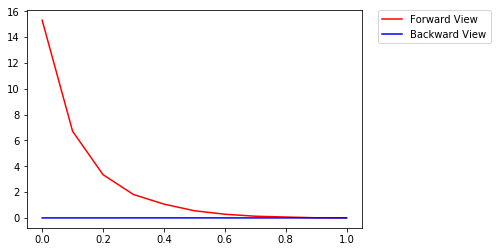

In [21]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(0,1,11), fv_acc, 'r', label='Forward View')
plt.plot(np.linspace(0,1,11), bv_acc, 'b', label='Backward View')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

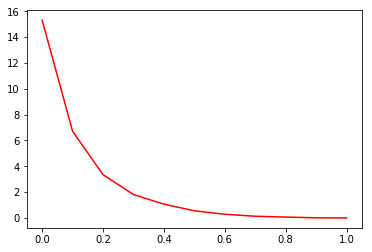

In [22]:
plt.plot(np.linspace(0,1,11), fv_acc, 'r', label='Forward View')
plt.show()

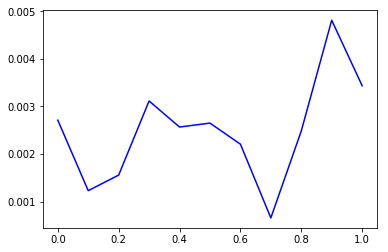

In [23]:
plt.plot(np.linspace(0,1,11), bv_acc, 'b', label='Backward View')
plt.show()

In [15]:
vf_pe_random = policy_eval(gw, random_policy, 1e-5)
vf_fv_random = forward_view_TD_lambda(random_policy, gw, 0.85, 5000, 30, 0.01)
vf_bv_random = backward_view_TD_lambda(random_policy, gw, 0.85, 5000, 30, 0.01)

In [16]:
for key in sorted(vf_pe_random.keys()):
    print(key, 'Policy Evaluation: {:0.3f} \tForward View: {:0.3f} \tBackward View: {:0.3f}'.format(vf_pe_random[key], vf_fv_random[key], vf_bv_random[key]))

(0, 0) Policy Evaluation: 0.000 	Forward View: 0.000 	Backward View: 0.000
(0, 1) Policy Evaluation: 0.721 	Forward View: 0.773 	Backward View: 0.731
(0, 2) Policy Evaluation: -0.638 	Forward View: -0.824 	Backward View: -0.726
(0, 3) Policy Evaluation: -0.425 	Forward View: -0.464 	Backward View: -0.401
(1, 0) Policy Evaluation: 0.954 	Forward View: 0.923 	Backward View: 0.973
(1, 1) Policy Evaluation: -0.229 	Forward View: -0.420 	Backward View: -0.273
(1, 2) Policy Evaluation: -0.347 	Forward View: -0.430 	Backward View: -0.279
(1, 3) Policy Evaluation: -0.638 	Forward View: -0.598 	Backward View: -0.609
(2, 0) Policy Evaluation: 0.294 	Forward View: 0.257 	Backward View: 0.310
(2, 1) Policy Evaluation: 0.026 	Forward View: -0.041 	Backward View: -0.040
(2, 2) Policy Evaluation: -0.229 	Forward View: -0.305 	Backward View: -0.196
(2, 3) Policy Evaluation: 0.721 	Forward View: 0.798 	Backward View: 0.619
(3, 0) Policy Evaluation: 0.196 	Forward View: 0.134 	Backward View: 0.278
(3, 1

In [17]:
fv_dist_random = average_squared_dist(vf_pe_random, vf_fv_random)
bv_dist_random = average_squared_dist(vf_pe_random, vf_bv_random)
print(fv_dist_random, bv_dist_random)

0.00733754865054568 0.003520974310142502


In [24]:
fv_acc_random = []
bv_acc_random = []
for lambd in np.linspace(0,1,11):
    fv_random = forward_view_TD_lambda(random_policy, gw, lambd, 5000, 30, 0.01)
    bv_random = backward_view_TD_lambda(random_policy, gw, lambd, 5000, 30, 0.01)
    fv_acc_random.append(average_squared_dist(vf_pe_random, fv_random))
    bv_acc_random.append(average_squared_dist(vf_pe_random, bv_random))

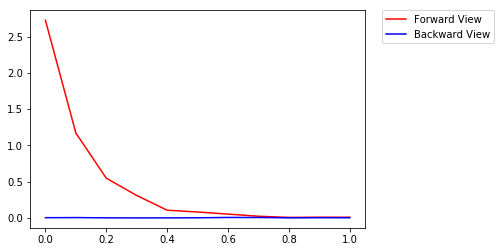

In [25]:
plt.plot(np.linspace(0,1,11), fv_acc_random, 'r', label='Forward View')
plt.plot(np.linspace(0,1,11), bv_acc_random, 'b', label='Backward View')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Proof that the Sum of Offline Updates are Identical for Forward-View and Backward-View TD
__Theorem:__
$$
\sum_{t=1}^T\alpha\delta_tE_t(s) = \sum_{t=1}^T\alpha\big(G_t^\lambda-V(S_t)\big)\mathbf 1(S_t = s) 
$$

__Proof:__
- Consider an episode where $s$ is visited only once, which happens at time-step $k$,
- TD($\lambda$) eligibility traces discounts time since visit,

$$ 
\begin{align}
E_t(s) & = \gamma \lambda E_{t-1}(s) + \mathbf 1(S_t = s)\\
\\
& = \begin{cases}
0 & \text{if } t<k\\
(\gamma\lambda)^{t-k} & \text{if } t\geq k
\end{cases}
\end{align}
$$

- TD($\lambda$) accumulates error online

$$
\sum_{t=1}^{T-1}\alpha\delta_tE_t(s) = \alpha\sum_{t=k}^{T-1}\delta_t(\gamma\lambda)^{t-k} = \alpha(G_k^\lambda - V(S_k))
$$
If we divide by $\alpha > 0$ we get
$$
\sum_{t=k}^{T-1}\delta_t(\gamma\lambda)^{t-k} = G_k^\lambda - V(S_k)
$$

- By the end of the episode this accumulates to

$$
\sum_{t=k}^{T-1}\delta_t(\gamma\lambda)^{t-k} = \delta_k + (\gamma\lambda)\delta_{k+1} + (\gamma\lambda)^{2}\delta_{k+2} + \dots + (\gamma\lambda)^{T-k-1}\delta_{T-1}
$$

- Remember, $\delta_t = R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$

- Telescoping the above error then gives us

$$
\begin{align}
\delta_k + (\gamma\lambda)\delta_{k+1} + (\gamma\lambda)^{2}\delta_{k+2} + \dots + (\gamma\lambda)^{T-k-1}\delta_{T-1}
& = R_{k+1} + \gamma V(S_{k+1}) - V(S_k) \\
& + \gamma\lambda R_{k+2} + \gamma(\gamma\lambda) V(S_{k+2}) - \gamma\lambda V(S_{k+1})\\
& + (\gamma\lambda)^2 R_{k+3} + \gamma(\gamma\lambda)^2 V(S_{k+3}) - (\gamma\lambda)^2 V(S_{k+2})\\
\vdots \\
& + (\gamma\lambda)^{T-k-1} R_{T} + \gamma(\gamma\lambda)^{T-k-1} V(S_{T}) - (\gamma\lambda)^{T-k-1} V(S_{T-1})\\
& = \sum_{t=k}^{T-1} (\gamma\lambda)^{t-k}R_{k+1} + \lambda \sum_{t=k}^{T-1} (\gamma\lambda)^{t-k}R_{k+1} - \lambda \sum_{t=k}^{T-1} (\gamma\lambda)^{t-k}R_{k+1} + (1 - \lambda) \sum_{t=k+1}^{T-1} V(S_t) - V(S_k)\\
& = (1-\lambda)\sum_{t=k}^{T-1}\lambda^{t-k}G_t^{(t-k)} + \lambda \sum_{t=k}^{T-1} (\gamma\lambda)^{t-k}R_{k+1} - V(S_k)\\
& = G_k^\lambda - V(S_k)
\end{align}
$$